# Single Player Multi-game Analysis

Look at a player's scoring over a range of games.

## Preliminaries

In [1]:
%matplotlib inline

In [2]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [3]:
DBFILE = 'CarcassonneScore-sample.db'

In [4]:
timefmt = "%Y-%m-%dT%H:%M:%S"

In [5]:
conn = sqlite3.connect(DBFILE)
cur = conn.cursor()

In [6]:
playerID = 0

In [7]:
# set up a dtype for storing data
pinfodtype = [('gameID', float),
              ('score', float)]

## Get General Information

In [8]:
pname = cur.execute('SELECT name FROM players WHERE playerID={0:1.0f}'.format(playerID)).fetchall()[0][0]

In [9]:
scoretypes = [x[0] for x in cur.execute('SELECT DISTINCT scoretype FROM scores WHERE playerID={0:1.0f}'.format(playerID)).fetchall()]

In [10]:
for stype in scoretypes:
    pinfodtype.append(('N' + stype, float))
    pinfodtype.append(('Score' + stype, float))

In [11]:
pinfo = np.zeros(1, dtype=pinfodtype)

### Get a list of relevant games

In [12]:
gameIDs = [x[0] for x in cur.execute('SELECT DISTINCT gameID FROM turns WHERE playerID={0:1.0f}'.format(playerID)).fetchall()]
for gameID in gameIDs:
    curgame = np.zeros(1, dtype=pinfodtype)
    curgame['gameID'] = gameID
    scores = cur.execute('SELECT points,scoretype FROM scores WHERE gameID={0:1.0f} AND playerID={1:1.0f}'.format(gameID, playerID)).fetchall()
    scores = np.array(scores,
                      dtype=[('points', float), 
                             ('type', 'S20')])
    for stype in scoretypes:
        tscores = scores[scores['type']==stype.encode()]
        curgame['N' + stype] = len(tscores)
        curgame['Score' + stype] = np.nansum(tscores['points'])
    pinfo = np.vstack((pinfo, curgame))

In [13]:
# remove bogus first entry
pinfo = pinfo[1:]

Text(0.5,1,'Scoring Habits for John Smith')

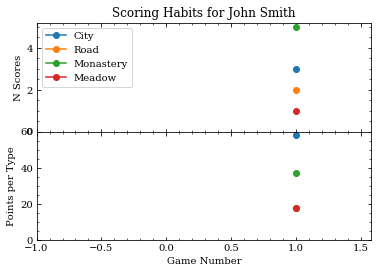

In [14]:
fig, ax = plt.subplots(2, 1,
                       sharex=True, sharey=False)
for stype in scoretypes:
    ax[0].plot(pinfo['gameID'],
               pinfo['N' + stype],
               marker='o',
               label=stype)
    ax[1].plot(pinfo['gameID'],
               pinfo['Score' + stype],
               marker='o',
               label=stype)

fig.subplots_adjust(hspace=0)
ax[0].set_ylabel('N Scores')
ax[1].set_ylabel('Points per Type')
ax[1].set_xlabel('Game Number')
ax[0].legend(loc='best')
ax[0].minorticks_on()
ax[1].minorticks_on()
ylim = ax[0].get_ylim()
ax[0].set_ylim([0, ylim[1]])
ylim = ax[1].get_ylim()
ax[1].set_ylim([0, ylim[1]])
xlim = ax[0].get_xlim()
ax[0].set_xlim(-1, xlim[1]*1.5)
ax[0].set_title('Scoring Habits for ' + pname)

## Close things up

In [15]:
conn.close()